In [11]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from gglm.cnncritic import CNNCritic

from sptr.sptr import SpikeTrain

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
npz = np.load('./fr_mismatch.npz')
t, stim, mask_spikes_te, u_spk_mean_te, mask_spikes_fr, u_spk_mean_fr  = npz['t'], npz['stim'], npz['mask_spikes_te'], npz['u_spk_mean_te'], npz['mask_spikes_fr'], npz['u_spk_mean_fr']
u_te, u_fr = npz['u_te'], npz['u_fr']
r_te, r_fr = npz['r_te'], npz['r_fr']
u0_ml, eta_vals_ml = npz['glm_u0'], npz['glm_eta']

dt = t[1]

n_batch_te = mask_spikes_te.shape[1]
n_batch_fr = mask_spikes_fr.shape[1]

st_te = SpikeTrain(t, mask_spikes_te)
st_fr = SpikeTrain(t, mask_spikes_fr)

mask_spikes = np.concatenate((mask_spikes_te, mask_spikes_fr), axis=1)
n_spikes_te = np.sum(mask_spikes_te, 0)
n_spikes_fr = np.sum(mask_spikes_fr, 0)
mask_spikes_te = torch.from_numpy(mask_spikes_te)
mask_spikes = torch.from_numpy(mask_spikes).double()
# y = np.concatenate((np.ones(mask_spikes_te.shape[1]), np.zeros(mask_spikes_fr.shape[1])))
y = torch.cat((torch.ones(n_batch_te), torch.zeros(n_batch_fr))).double()
u = torch.from_numpy(np.concatenate((u_te, u_fr), axis=1)).double()
r = torch.from_numpy(np.concatenate((r_te, r_fr), axis=1)).double()

x = torch.stack((mask_spikes.T, u.T), dim=1)

ms = 1

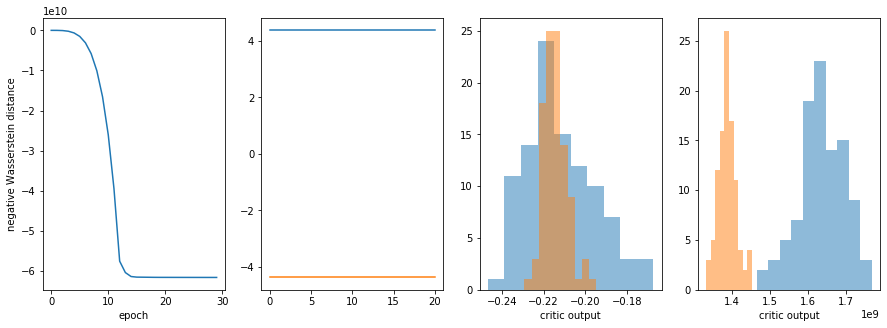

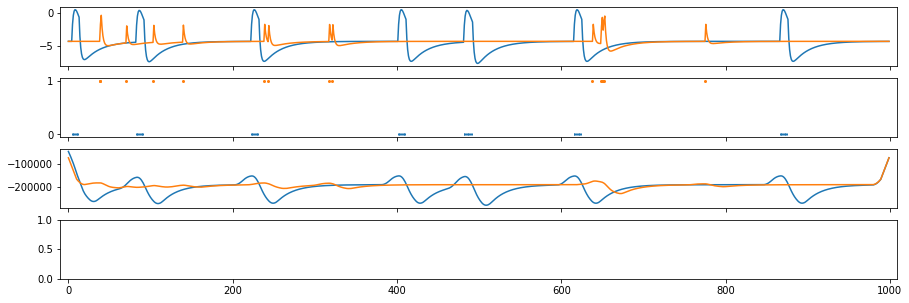

In [16]:
lam_w, num_epochs, lr_g, lr_c, clip = 2.5e2, 120, 2e-2, 1e0, 1e1 # normalized

critic = CNNCritic(n=mask_spikes.shape[0], two_layers=True, kernel_size=21, cnn_bias=True, weight_normalization=False, 
                   cnn_output_window=100, clip=clip)
output0 = critic(x)
output0 = output0.detach().numpy()

# neg_w_distance = critic.train(t, mask_spikes, u, r, y, lam_w, lr=lr_c, num_epochs=30)

x = torch.stack((mask_spikes.T, u.T), dim=1)
neg_w_distance = critic.train(x, y, lam_w, lr=lr_c, num_epochs=30)

output = critic(x)
output = output.detach().numpy()
cnn_output = critic.cnn_layers(x).detach().numpy()
cnn_output_te = cnn_output[:n_batch_te, :, :]
cnn_output_fr = cnn_output[n_batch_te:, :, :]

sw = 0
t_cnn_output = np.arange(0, cnn_output_te.shape[2], 1) * len(t) // critic.cnn_output_window

kernel, bias = critic.cnn_layers[0].weight, critic.cnn_layers[0].bias
# kernel, bias = critic.cnn_spikes_layers[0].weight, critic.cnn_spikes_layers[0].bias
if bias is None:
    bias = 0
    kernel = kernel.detach().numpy()
else:
    kernel = kernel.detach().numpy() + bias.detach().numpy()[:, None, None]

t_kernel = np.arange(0, kernel.shape[2], 1) * dt

fig, (ax1, ax2, ax3, ax4) = plt.subplots(figsize=(15, 5), ncols=4)
ax1.plot(neg_w_distance)
ax1.set_xlabel('epoch')
ax1.set_ylabel('negative Wasserstein distance')
ax2.plot(t_kernel, kernel[0, 0, :])
ax2.plot(t_kernel, kernel[1, 0, :])
ax3.hist(output0[y == 1], alpha=0.5)
ax3.hist(output0[y == 0], alpha=0.5)
ax4.hist(output[y == 1], alpha=0.5)
ax4.hist(output[y == 0], alpha=0.5)
ax3.set_xlabel('critic output')
ax4.set_xlabel('critic output')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(figsize=(15, 5), nrows=4, sharex=True)
ax1.plot(t, u_te[:, sw])
ax1.plot(t, u_fr[:, sw])
st_te.plot(ax=ax2, sweeps=sw, marker='|', ms=2)
st_fr.plot(ax=ax2, offset=1, sweeps=sw, ms=2, color='C1')
# ax2.plot(t, r_fr[:, 0])
ax3.plot(t, cnn_output_te[sw, 0, :])
ax3.plot(t, cnn_output_fr[sw, 0, :])
if cnn_output_fr.shape[1] > 1:
    ax4.plot(t, cnn_output_te[sw, 1, :])
    ax4.plot(t, cnn_output_fr[sw, 1, :])
# ax1.plot(t, critic_conv_fr[:, 0])

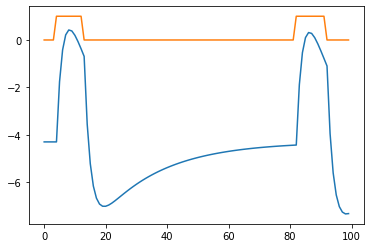

In [24]:
plt.plot(t[:100], u_te[:100, 0])
plt.plot(t[:100], mask_spikes_te[:100, 0])

In [37]:
critic.cnn_layers[0].weight.data[0, ...] = torch.ones(critic.cnn_layers[0].weight.data[0, ...].shape)
critic.cnn_layers[0].weight.data[0, ...]

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1.]], dtype=torch.float64)

In [9]:
np.linalg.norm(kernel, axis=2, ord=2)

array([[46.80142234],
       [46.79629874]])

In [10]:
dim = 2
print(torch.norm(critic.cnn_layers[0].weight, dim=dim))
print(torch.norm(critic.cnn_layers[0].weight_g, dim=dim))
print(torch.norm(critic.cnn_layers[0].weight_v, dim=dim))
# print(critic.cnn_layers[0].weight, critic.cnn_layers[0].weight_g, critic.cnn_layers[0].weight_v)

tensor([[1.0000],
        [1.0000]], dtype=torch.float64, grad_fn=<NormBackward3>)
tensor([[1.],
        [1.]], dtype=torch.float64)
tensor([[1.0000],
        [1.0000]], dtype=torch.float64, grad_fn=<NormBackward3>)


In [8]:
critic.cnn_layers[0].weight_v.shape

torch.Size([2, 1, 21])

In [10]:
critic.cnn_layers[0].weight_v

Parameter containing:
tensor([[[0.0567, 0.0653, 0.0741, 0.0828, 0.0933, 0.1041, 0.1179, 0.1377,
          0.1604, 0.2013, 0.2582, 0.3305, 0.3038, 0.2991, 0.2913, 0.2854,
          0.2778, 0.2681, 0.2593, 0.2500, 0.2426]],

        [[0.2182, 0.2182, 0.2182, 0.2182, 0.2182, 0.2182, 0.2182, 0.2182,
          0.2182, 0.2182, 0.2182, 0.2182, 0.2182, 0.2182, 0.2182, 0.2182,
          0.2182, 0.2182, 0.2182, 0.2182, 0.2182]]], dtype=torch.float64,
       requires_grad=True)

In [149]:
critic.cnn_layers[0].weight.shape, critic.cnn_layers[0].weight_v.shape, critic.cnn_layers[0].weight_g.shape

(torch.Size([2, 1, 21]), torch.Size([2, 1, 21]), torch.Size([2, 1, 1]))

In [122]:
dim = 2
print(torch.norm(critic.cnn_spikes_layers[0].weight, dim=dim))
print(torch.norm(critic.cnn_spikes_layers[0].weight_g, dim=dim))
print(torch.norm(critic.cnn_spikes_layers[0].weight_v, dim=dim))
# print(critic.cnn_layers[0].weight, critic.cnn_layers[0].weight_g, critic.cnn_layers[0].weight_v)

tensor([[1.]], dtype=torch.float64, grad_fn=<NormBackward3>)
tensor([[1.]], dtype=torch.float64)
tensor([[8.0000]], dtype=torch.float64, grad_fn=<NormBackward3>)


In [145]:
critic.cnn_spikes_layers[0].weight_g

AttributeError: 'CNNCritic' object has no attribute 'cnn_spikes_layers'

In [124]:
critic.cnn_spikes_layers[0].weight.shape, critic.cnn_spikes_layers[0].weight_v.shape, critic.cnn_spikes_layers[0].weight_g.shape

(torch.Size([1, 1, 21]), torch.Size([1, 1, 21]), torch.Size([1, 1, 1]))

AttributeError: 'CNNCritic' object has no attribute 'cnn_layers'

torch.Size([2, 1, 21])